In [1]:
import pandas as pd, numpy as np
import os
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from ResearchML import *
from mlfinlab.microstructural_features import *
from mlfinlab.sample_weights import *
from sklearn.ensemble import RandomForestClassifier

workPath = "/home/xetra/AlphaGoldmine/Data/"
future = "CL"
y = 2018

contFuture = os.path.join(workPath, future.lower(), f"{future}Cont")
contFutureMLOLD = os.path.join(workPath, future.lower(), f"{future}ContML")

vbPath = os.path.join(workPath, future.lower(), f"{future}ContVB")
contFutureLevelBucketsVB = os.path.join(workPath,future.lower(), f"{future}ContLevelBuckets")
vpDir = os.path.join(workPath,future.lower(),"VP")

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100


snippedFrom = 2016


error uploading: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f60e4587850>: Failed to establish a new connection: [Errno -2] Name or service not known'))


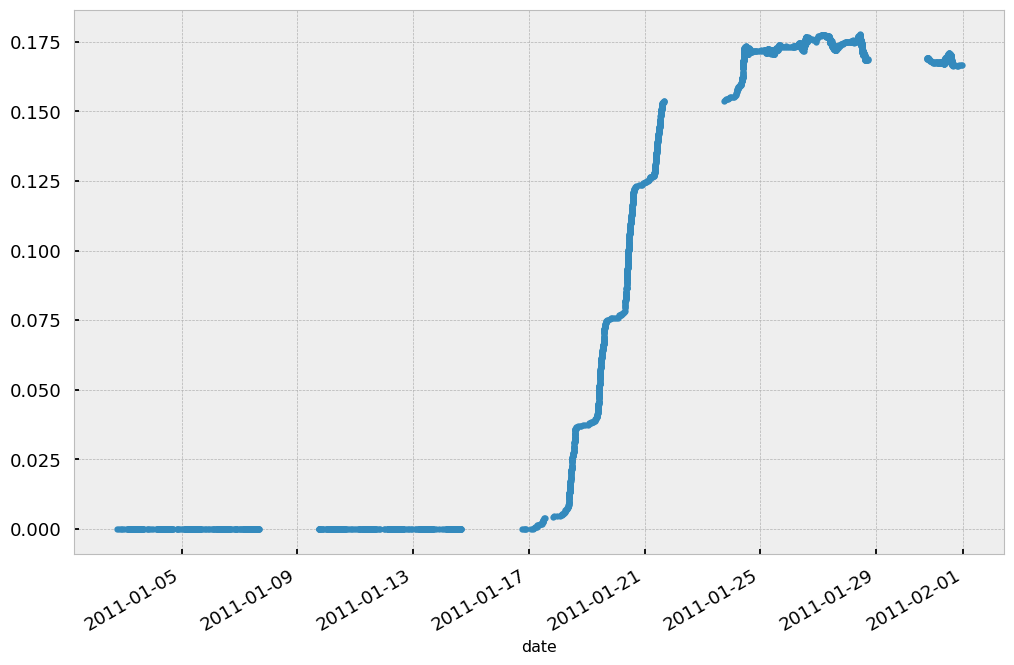

In [2]:
df = pd.read_feather(contFuture).set_index("date")
vb = pd.read_feather(vbPath).set_index("date")
vb.loc[(vb.index.year==2011)&(vb.index.month==1),"VPIN"].plot(style=".")
vb = vb.loc[vb.index.date>=parse("2011-01-25").date()] #cut out bad data due to missing volume

In [3]:
dfMl = pd.read_feather(contFutureLevelBucketsVB).set_index("date")
dfOld = pd.read_feather(contFutureMLOLD).set_index("date")

In [4]:
df = df[df.index.year >= snippedFrom]
vb = vb[vb.index.year >= snippedFrom]
dfMl = dfMl[dfMl.index.year >= snippedFrom]
dfOld = dfOld[dfOld.index.year >= snippedFrom]

In [5]:
cols = ["relCVD","OFI",'ttFomc','ttInv','teaCVbCUSUM','teaVToPCUSUM','ttUsOpen','ttEuOpen','ttUsClose','teaFomc', 'teaInv']
buckets = [c for c in dfMl.columns if c.endswith("B")]
vb.loc[vb.index,buckets] = dfMl.loc[dfMl.index.intersection(vb.index),buckets]
vb.loc[vb.index,cols] = dfMl.loc[dfMl.index.intersection(vb.index),cols]
vb["teaInv"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.inv==1].index,y=-.7)
vb["teaFomc"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.fomc==1].index,y=-.7)
vb["teaCVbCUSUM"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.cVbCUSUM==1].index,y=-.7)
vb["teaVToPCUSUM"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.vToPCUSUM==1].index,y=-.7)

In [6]:
vb = vb.drop("teaVToPCUSUM",1)

In [7]:
vb = vb.drop("VPIN",1)

In [8]:
vb.columns

Index(['oVb', 'hVb', 'lVb', 'cVb', 'volVb', 'nrTVb', 'bidVolVb', 'askVolVb',
       'asiaSesHB', 'asiaSesLB', 'euSesHB', 'euSesLB', 'usSesHB', 'usSesLB',
       'o1DB', 'h1DB', 'l1DB', 'c1DB', 'retrDB', 'o1WB', 'h1WB', 'l1WB',
       'c1WB', 'retrWB', 'o1MB', 'h1MB', 'l1MB', 'c1MB', 'retrMB', 'valB',
       'vahB', 'pocB', 'relCVD', 'OFI', 'ttFomc', 'ttInv', 'teaCVbCUSUM',
       'ttUsOpen', 'ttEuOpen', 'ttUsClose', 'teaFomc', 'teaInv'],
      dtype='object')

In [9]:
vb["rPrices"] = df.loc[vb.index,"rPrices"]

In [10]:
window=500

In [11]:
vb["RollImpact"] = get_roll_impact(vb.cVb,vb.cVb*vb.volVb,window=window)

In [12]:
vb["SpreadEst"] = get_corwin_schultz_estimator(vb.hVb,vb.lVb,window=window)

In [13]:
vb["vola"] = get_bekker_parkinson_vol(vb.hVb,vb.lVb,window=window)

In [14]:
vb["KylesLambda"] = get_bar_based_kyle_lambda(vb.cVb,vb.volVb,window=window)

In [15]:
vb["AmihudLambda"] = get_bar_based_amihud_lambda(vb.cVb,vb.cVb*vb.volVb,window=window)

In [16]:
vb["hasbroukLambda"] = get_bar_based_hasbrouck_lambda(vb.cVb,vb.cVb*vb.volVb,window=window)

In [17]:
vb["VPIN"] = get_vpin(vb.cVb, vb.askVolVb,window=window)

In [18]:
colsToDrop = [
    "oVb",
    "hVb",
    "lVb",
    "volVb",
    "nrTVb",
    "bidVolVb",
    "askVolVb",
]

In [19]:
vb = vb.drop(colsToDrop,1)

In [20]:
# Prep for ML for window=500

In [21]:
span=100

In [22]:
import os


In [23]:
eventsPath=f"events-vol{span}-window{window}"
trgt = getDailyVol(vb.cVb,span0=span)
# t1 = getT1(df["c"],vb.index,span=pd.Timedelta(hours=8))
if os.path.exists(eventsPath): events=pd.read_feather(eventsPath).set_index("date")
else: 
    events=getEvents(close=df["c"],tEvents=vb.index,ptSl=[1],trgt=trgt,minRet=trgt.quantile(0.25),numThreads=10)#,t1=t1)
    events.reset_index().to_feather(eventsPath)
out = getBins(events=events,close=df["c"])
# out = out[out.bin != 0]
# events = events.loc[out.index]

In [24]:
events = events[events.index.year >= snippedFrom]
out = out[out.index.year >= snippedFrom]

In [25]:
out.bin.value_counts()

-1.0    142377
 1.0    138964
Name: bin, dtype: int64

In [26]:
### Overlapping Labels

In [27]:
# numCoEvents=mpPandasObj(mpNumCoEvents,("molecule",events.index),numThreads=12,closeIdx=vb.index,t1=events["t1"])
# numCoEvents=numCoEvents.loc[~numCoEvents.index.duplicated(keep="last")]
# numCoEvents=numCoEvents.reindex(vb.index).fillna(0)
# out["tW"]=mpPandasObj(mpSampleTW,("molecule",events.index),numThreads=12,t1=events["t1"],numCoEvents=numCoEvents)
# out["w"]=mpPandasObj(mpSampleW,("molecule",events.index),numThreads=12,t1=events["t1"],numCoEvents=numCoEvents,close=df.c)

In [28]:
w = get_weights_by_return(events.dropna(),vb.cVb,12)

2021-03-19 10:24:32.615661 100.0% num_concurrent_events done after 0.43 minutes. Remaining 0.0 minutes.
2021-03-19 10:24:57.789438 100.0% _apply_weight_by_return done after 0.41 minutes. Remaining 0.0 minutes.


<AxesSubplot:>

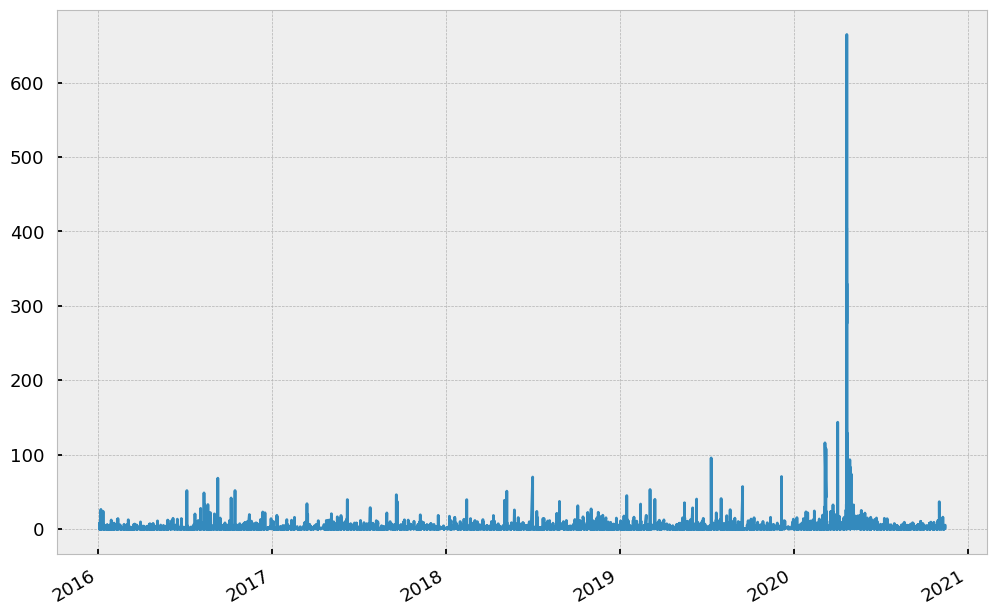

In [29]:
w.plot()

In [30]:
# clf0 = DecisionTreeClassifier(criterion="entropy",max_features="auto",class_weight="balanced")
clf0 = RandomForestClassifier(n_estimators=1,criterion="entropy",bootstrap=False,class_weight="balanced_subsample")
# clf0 = BaggingClassifier(base_estimator=clf1,n_estimators=1000,max_samples=avgU.mean(),n_jobs=-1)

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, log_loss

In [32]:
clf2 = RandomForestClassifier(n_estimators=1,criterion="entropy",bootstrap=False,class_weight="balanced_subsample")
clf2 = BaggingClassifier(base_estimator=clf2,n_estimators=1000,max_samples=0.5,max_features=1.,oob_score=True,n_jobs=-1)

In [33]:
X = vb.loc[vb.index.year<2019].drop("cVb",1).mul(w.loc[w.index.year<2019],0)
y = out.loc[out.index.year<2019,"bin"]

In [34]:
idx=X.dropna().index

In [35]:
clf2.fit(X.loc[idx],y.loc[idx])

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        class_weight='balanced_subsample',
                                                        criterion='entropy',
                                                        n_estimators=1),
                  max_samples=0.5, n_estimators=1000, n_jobs=-1,
                  oob_score=True)

In [36]:
from mlfinlab.cross_validation import *

In [37]:
cv_gen = PurgedKFold(n_splits=5, samples_info_sets=events.loc[idx,"t1"], pct_embargo=0.1)
oos = ml_cross_val_score(clf2,X.loc[idx],y.loc[idx],cv_gen,sample_weight_train=w.loc[idx],scoring=log_loss)

## Feature Importance Analyzis

In [38]:
from mlfinlab.feature_importance import *

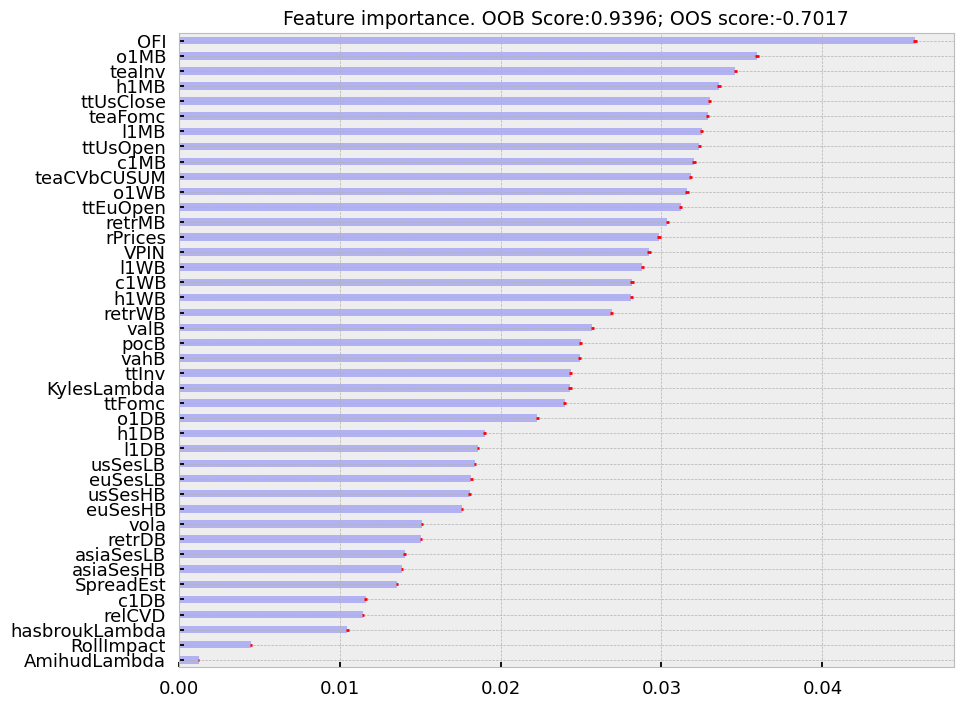

In [39]:
mdi=mean_decrease_impurity(clf2,X.columns)
plot_feature_importance(mdi,
oob_score=clf2.oob_score_,
oos_score=oos.mean(),
)

### Mean Decrease Accuracy
MDA feature importance with sample
weights, with purged k-fold CV, and with scoring by negative log-loss
or accuracy. It measures MDA importance as a function of the
improvement (from permutating to not permutating the feature),
relative to the maximum possible score (negative log-loss of 0, or
accuracy of 1). Note that, in some cases, the improvement may be
**negative**, meaning that the feature is actually **detrimental** to the
forecasting power of the ML algorithm.


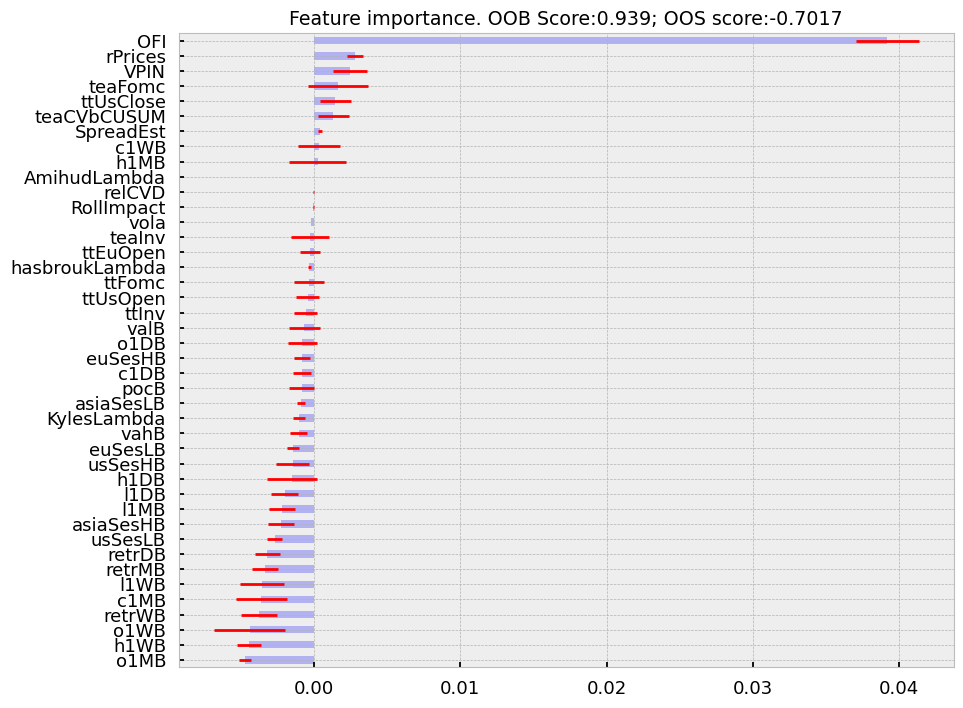

In [40]:
mda=mean_decrease_accuracy(clf2,X.loc[idx],y.loc[idx],cv_gen,sample_weight_train=w.loc[idx],scoring=log_loss)
plot_feature_importance(mda,
oob_score=clf2.oob_score_,
oos_score=oos.mean(),
)

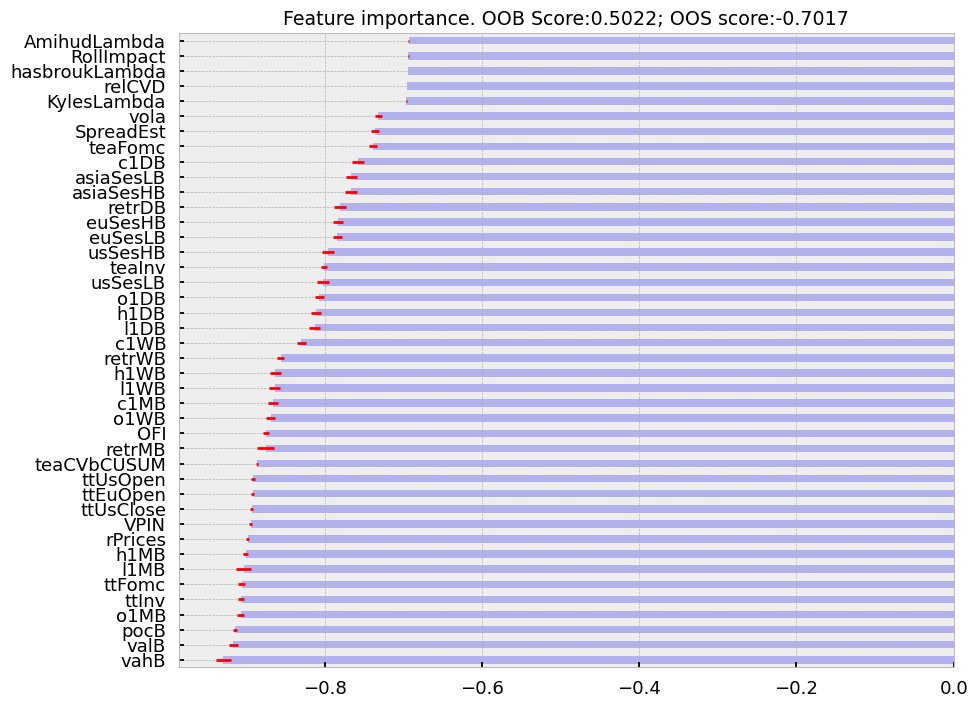

In [41]:
sfi = single_feature_importance(clf2,X.loc[idx],y.loc[idx],cv_gen,sample_weight_train=w.loc[idx],scoring=log_loss)
plot_feature_importance(sfi,
oob_score=clf2.oob_score_,
oos_score=oos.mean(),
)